## Прогнозирование потребления ТЭР

Загружаем необходимые библиотеки.

In [9]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import joblib
import os
from itertools import product
import time
import glob 
import json
from datetime import datetime
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import warnings
from sklearn.model_selection import train_test_split, GridSearchCV
import re
from tensorflow.keras.models import load_model

In [10]:
warnings.filterwarnings('ignore') # игнорируем предупреждения для чистоты вывода

## 1. Сбор исходных данных.

1.1. Скачиваем исходный файл, преобразуем в dataframe и выводим названия имеющихся листов.

In [11]:
# указываем путь к файлу с dataset
file_path = r'D:/Python/Final_certification/ФЦ_2022_2025_v2.xlsx'
# считываем файл и выводим список имеющихся листов
excel_file = pd.ExcelFile(file_path)
sheet_names = excel_file.sheet_names
print("Названия листов в файле:")
for i, name in enumerate(sheet_names):
    print(f"{i+1}. {name}")

Названия листов в файле:
1. prod_17
2. prod_18
3. prod_19
4. prod_20
5. prod_21
6. prod_22
7. prod_23
8. prod_24
9. prod_25
10. el_17
11. el_18
12. el_19
13. el_20
14. el_21
15. el_22
16. el_23
17. el_24
18. el_25
19. 2022г
20. 2023г
21. 2024г
22. 2025г
23. total
24. total (2)


1.2. Считываем листы с объемами продукции, сохраняем в один dataframe.

In [12]:
# считываем листы с объемами выпуска продукции и сохраняем их в dataframe
df_prod_17 = pd.read_excel(file_path, sheet_name="prod_17")
df_prod_18 = pd.read_excel(file_path, sheet_name="prod_18")
df_prod_19 = pd.read_excel(file_path, sheet_name="prod_19")
df_prod_20 = pd.read_excel(file_path, sheet_name="prod_20")
df_prod_21 = pd.read_excel(file_path, sheet_name="prod_21")
df_prod_22 = pd.read_excel(file_path, sheet_name="prod_22")
df_prod_23 = pd.read_excel(file_path, sheet_name="prod_23")
df_prod_24 = pd.read_excel(file_path, sheet_name="prod_24")
df_prod_25 = pd.read_excel(file_path, sheet_name="prod_25")
prod_2225 = pd.concat([df_prod_17, df_prod_18, df_prod_19, df_prod_20, df_prod_21, df_prod_22, df_prod_23, df_prod_24, df_prod_25])
display(prod_2225)

,Date,Prod.,0,1,2,3,4,5
0,2017-01-01,0.0,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-01-02,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2017-01-03,0.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2017-01-04,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2017-01-05,0.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
361,2025-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN
362,2025-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
363,2025-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN
364,2025-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN


1.3. Считываем листы с потреблением эл.энергии и сохраняем информацию в один dataframe.

In [13]:
# считываем листы с объемами потребления эл.энергии и сохраняем их в dataframe
df_el_17 = pd.read_excel(file_path, sheet_name="el_17")
df_el_18 = pd.read_excel(file_path, sheet_name="el_18")
df_el_19 = pd.read_excel(file_path, sheet_name="el_19")
df_el_20 = pd.read_excel(file_path, sheet_name="el_20")
df_el_21 = pd.read_excel(file_path, sheet_name="el_21")
df_el_22 = pd.read_excel(file_path, sheet_name="el_22")
df_el_23 = pd.read_excel(file_path, sheet_name="el_23")
df_el_24 = pd.read_excel(file_path, sheet_name="el_24")
df_el_25 = pd.read_excel(file_path, sheet_name="el_25")
el_2225 = pd.concat([df_el_17, df_el_18, df_el_19, df_el_20, df_el_21, df_el_22, df_el_23, df_el_24, df_el_25])
display(el_2225)

,Date,яч.11(ид.1),яч.7(ид.2),яч.19(ид.3),яч.1А(ид.4),яч.5(ид.5),яч.17(ид.6),Транзиты,Total_el_en,яч.17(ид.24),яч.3(ид.6),яч.23(ид.3366)
0,2017-01-01,1012.0,964.7,676.5,39.0,701.0,1466.0,1145.6,3713.6,NaN,NaN,NaN
1,2017-01-02,1007.0,975.0,669.0,39.0,701.0,1314.0,970.8,3734.2,NaN,NaN,NaN
2,2017-01-03,845.6,994.7,650.0,122.8,693.0,1380.0,1020.3,3665.8,NaN,NaN,NaN
3,2017-01-04,1197.0,1172.0,965.0,1199.9,564.0,2426.0,1436.0,6087.9,NaN,NaN,NaN
4,2017-01-05,1319.0,1170.7,1051.5,432.0,677.0,2526.0,1436.7,5739.5,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
363,2025-12-30,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
364,2025-12-31,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
365,2026-01-01,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0
366,2026-01-02,0.0,0.0,0.0,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0


1.4. Объединяем два dataframe по столбцу date.

In [14]:
# объединяем два DataFrame по столбцу Date
df_prod_el = pd.merge(prod_2225, el_2225, on='Date')
df_prod_el = df_prod_el[['Date', 'Prod.', 'Total_el_en']] # выберем три столбца из датафрейма
display(df_prod_el)

,Date,Prod.,Total_el_en
0,2017-01-01,0.0,3713.6
1,2017-01-02,0.0,3734.2
2,2017-01-03,0.0,3665.8
3,2017-01-04,0.0,6087.9
4,2017-01-05,0.0,5739.5
...,...,...,...
3285,2025-12-28,NaN,0.0
3286,2025-12-29,NaN,0.0
3287,2025-12-30,NaN,0.0
3288,2025-12-31,NaN,0.0


## 2. Исследовательский анализ собранных данных.

2.1. Для первичного анализа и понимания структуры данных построим график временных рядов

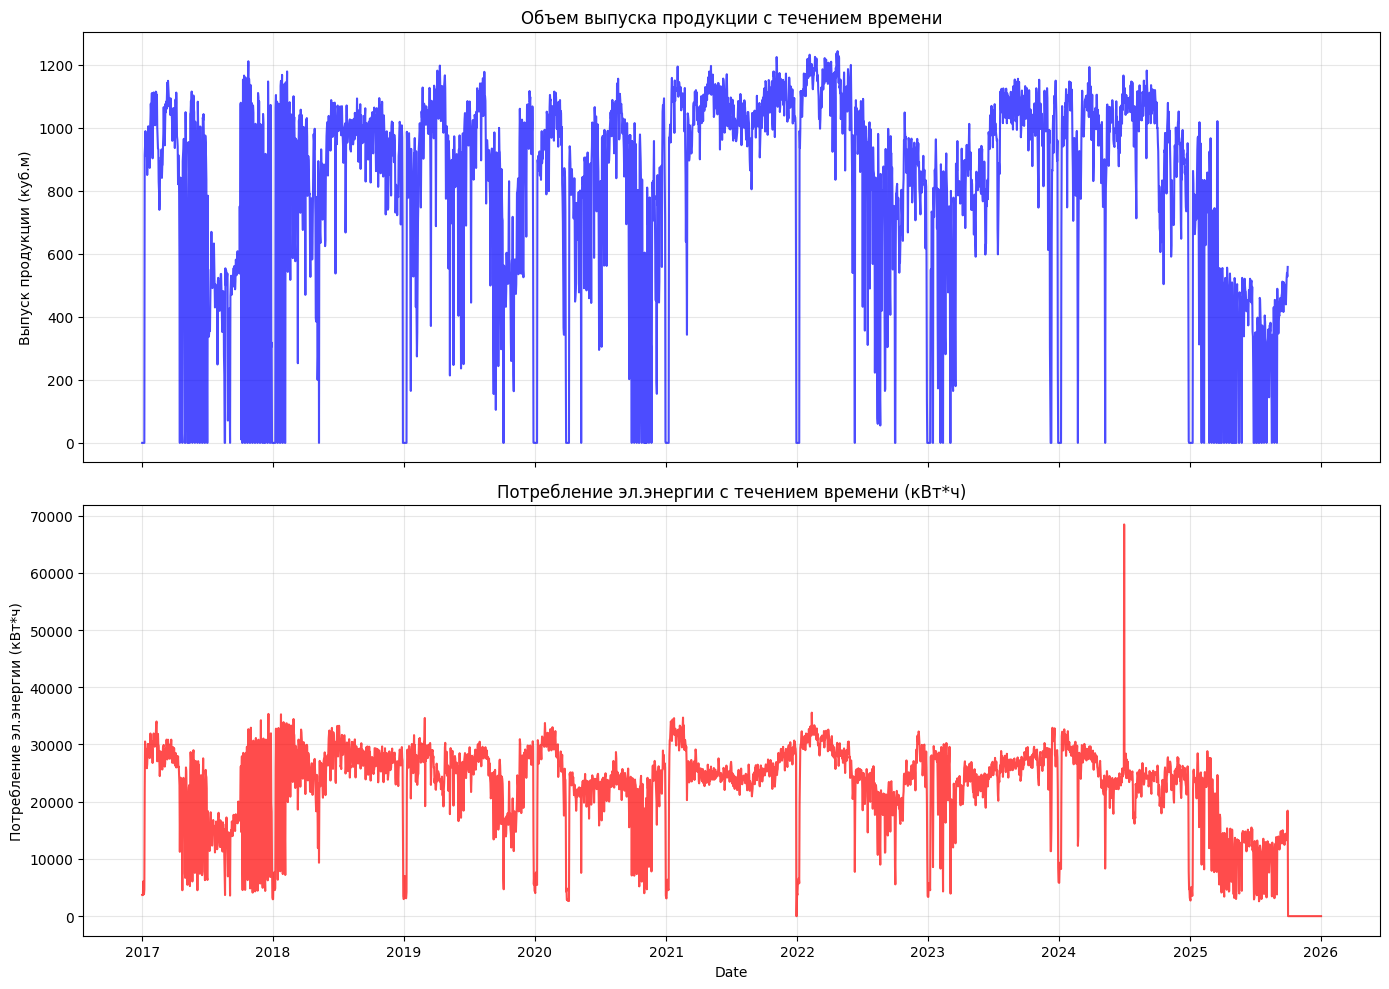

In [15]:
# убедимся, что 'Date' является datetime и индексом
df_prod_el['Date'] = pd.to_datetime(df_prod_el['Date'])

# создадим папку для хранения диаграмм и графиков
output_dir = "Диагр_графики"
os.makedirs(output_dir,exist_ok=True)
# формируем полный путь к файлу
file_path_1 = os.path.join(output_dir, "Prod_energy_consumption.png")

# создаем полотно с 2 подграфиками (с общей осью Х)
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# строим график выпуска продукции
axes[0].plot(df_prod_el['Date'], df_prod_el['Prod.'], label='Production Volume', color='blue', alpha=0.7)
axes[0].set_ylabel('Выпуск продукции (куб.м)')
axes[0].set_title('Объем выпуска продукции с течением времени')
axes[0].grid(True, alpha=0.3)

# строим график потребления электроэнергии
axes[1].plot(df_prod_el['Date'], df_prod_el['Total_el_en'], label='Energy Consumption', color='red', alpha=0.7)
axes[1].set_ylabel('Потребление эл.энергии (кВт*ч)')
axes[1].set_xlabel('Date') # Ось X только для нижнего графика, так как sharex=True
axes[1].set_title('Потребление эл.энергии с течением времени (кВт*ч)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout() # для исключения наложения графиков
plt.savefig(file_path_1, dpi=300) # dpi - разрешение для .png
plt.show()

2.2. Оценим корреляцию между потреблением эл.энергии и выпуском продукции

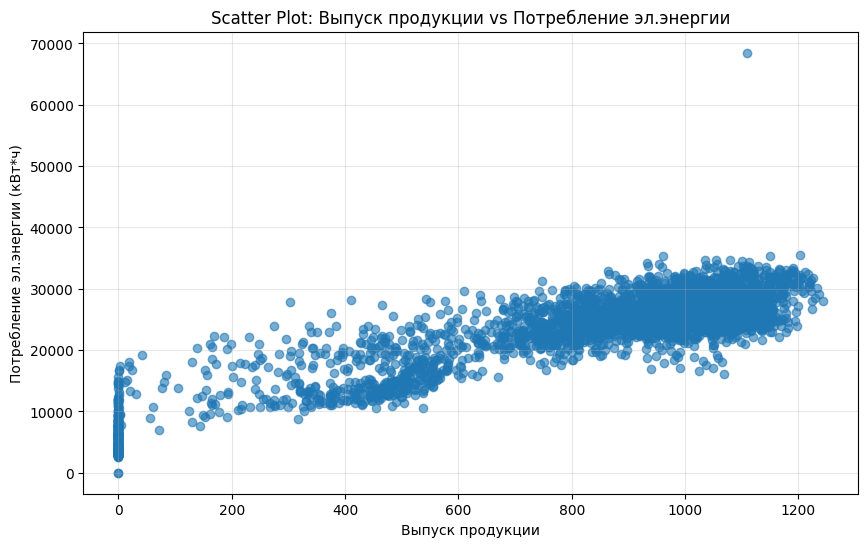

Корреляция между Prod. и Total_el_en: 0.8780


In [16]:
# построим диаграмму рассеяния
# формируем полный путь к файлу с графиком
file_path_2 = os.path.join(output_dir, "Prod_vs_energy.png")

plt.figure(figsize=(10, 6))
plt.scatter(df_prod_el['Prod.'], df_prod_el['Total_el_en'], alpha=0.6)
plt.xlabel('Выпуск продукции')
plt.ylabel('Потребление эл.энергии (кВт*ч)')
plt.title('Scatter Plot: Выпуск продукции vs Потребление эл.энергии')
plt.grid(True, alpha=0.3)
# сохраняем диаграмму в папку Диагр_графики
plt.savefig(file_path_2, dpi=300) # dpi - разрешение для .png
plt.show()

# посчитаем коэффициент корреляции Пирсона
correlation = df_prod_el['Prod.'].corr(df_prod_el['Total_el_en'])
print(f"Корреляция между Prod. и Total_el_en: {correlation:.4f}")

## 3. Создание дополнительных признаков и очистка данных.

3.1. Добавляем дополнительные признаки.

In [17]:
# добавляем признаки сезона
df_prod_el['month'] = df_prod_el['Date'].dt.month # месяц

# функция возвращает название сезона
def assign_season(month):
    if month in (12, 1, 2):
        return 'winter'
    elif month in (3, 4, 5):
        return 'spring'
    elif month in (6, 7, 8):
        return 'summer'
    else:
        return 'autumn'

# добавляем колонку season
df_prod_el['season'] = df_prod_el['month'].apply(assign_season)

# преобразуем season в четыре бинарных столбца
season_dummies = pd.get_dummies(df_prod_el['season'])

# объединяем исходный DataFrame и новые столбцы
df_prod_el = pd.concat([df_prod_el, season_dummies], axis=1)

# удаляем вспомогательный столбец 'season'
df_prod_el.drop(columns=['season'], inplace=True)

# создаем список столбцов с булевыми переменными
bool_cols = ['winter', 'spring', 'summer', 'autumn']

# приведем булевы переменные, из списка столбцов, к целым (0 и 1)
df_prod_el[bool_cols] = df_prod_el[bool_cols].astype(int)

display(df_prod_el)

,Date,Prod.,Total_el_en,month,autumn,spring,summer,winter
0,2017-01-01,0.0,3713.6,1,0,0,0,1
1,2017-01-02,0.0,3734.2,1,0,0,0,1
2,2017-01-03,0.0,3665.8,1,0,0,0,1
3,2017-01-04,0.0,6087.9,1,0,0,0,1
4,2017-01-05,0.0,5739.5,1,0,0,0,1
...,...,...,...,...,...,...,...,...
3285,2025-12-28,NaN,0.0,12,0,0,0,1
3286,2025-12-29,NaN,0.0,12,0,0,0,1
3287,2025-12-30,NaN,0.0,12,0,0,0,1
3288,2025-12-31,NaN,0.0,12,0,0,0,1


3.2. Посмотрим статисткику по переменным и проверим типы данных.

In [18]:
# посмотрим статистику по числовым переменным
display(df_prod_el.describe())
# проверка типов данных
display(df_prod_el.dtypes)

,Date,Prod.,Total_el_en,month,autumn,spring,summer,winter
count,3290,3197.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000,3290.000000
mean,2021-07-03 06:39:36.656535040,815.695387,22611.195632,6.518237,0.248936,0.251672,0.251672,0.247720
min,2017-01-01 00:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-04-03 06:00:00,701.700000,20658.007500,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2021-07-03 12:00:00,937.690000,24736.095000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-10-03 18:00:00,1049.660000,27737.772500,10.000000,0.000000,1.000000,1.000000,0.000000
max,2026-01-01 00:00:00,1243.600000,68453.860000,12.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,328.477074,7800.168046,3.451590,0.432462,0.434040,0.434040,0.431754


Date           datetime64[ns]
Prod.                 float64
Total_el_en           float64
month                   int32
autumn                  int32
spring                  int32
summer                  int32
winter                  int32
dtype: object

3.3. Удаляем выброс и строки с пропусками.

In [19]:
# выявлен выброс! находим индекс строки с max потреблением (в столбце 'Total_el_en')
index_max_el = df_prod_el['Total_el_en'].idxmax()
# выбираем всю строку с этим индексом
row_with_max_el = df_prod_el.loc[index_max_el]
display(row_with_max_el)

df_prod_el.drop(index_max_el, inplace=True)
display(df_prod_el.describe())

# удаляем строки, в которых отсутствуют данные о выпуске продукции
df_prod_el = df_prod_el.dropna(subset=['Prod.'])
display(df_prod_el)

Date           2024-07-01 00:00:00
Prod.                      1108.58
Total_el_en               68453.86
month                            7
autumn                           0
spring                           0
summer                           1
winter                           0
Name: 2738, dtype: object

,Date,Prod.,Total_el_en,month,autumn,spring,summer,winter
count,3289,3196.000000,3289.000000,3289.000000,3289.000000,3289.000000,3289.000000,3289.000000
mean,2021-07-02 22:40:45.241714688,815.603746,22597.257455,6.518091,0.249012,0.251748,0.251444,0.247796
min,2017-01-01 00:00:00,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,2019-04-03 00:00:00,701.640000,20652.720000,4.000000,0.000000,0.000000,0.000000,0.000000
50%,2021-07-03 00:00:00,937.495000,24735.700000,7.000000,0.000000,0.000000,0.000000,0.000000
75%,2023-10-03 00:00:00,1049.645000,27736.400000,10.000000,0.000000,1.000000,1.000000,0.000000
max,2026-01-01 00:00:00,1243.600000,35559.520000,12.000000,1.000000,1.000000,1.000000,1.000000
std,NaN,328.487597,7760.268949,3.452104,0.432506,0.434083,0.433909,0.431798


,Date,Prod.,Total_el_en,month,autumn,spring,summer,winter
0,2017-01-01,0.00,3713.600,1,0,0,0,1
1,2017-01-02,0.00,3734.200,1,0,0,0,1
2,2017-01-03,0.00,3665.800,1,0,0,0,1
3,2017-01-04,0.00,6087.900,1,0,0,0,1
4,2017-01-05,0.00,5739.500,1,0,0,0,1
...,...,...,...,...,...,...,...,...
3192,2025-09-26,481.52,13962.213,9,1,0,0,0
3193,2025-09-27,523.80,13415.300,9,1,0,0,0
3194,2025-09-28,539.74,13585.100,9,1,0,0,0
3195,2025-09-29,527.65,18267.840,9,1,0,0,0


## 4. Подготовка данных.

4.1. Создаем дополнительные лаговые признаки.

In [20]:
# создание новых признаков (для улучшения обучения модели):
# создаем функцию с аргументом df_prod_el
def engineer_features(df_prod_el):
    df_prod_el = df_prod_el.copy() # резерв имени
    # лаговые признаки (создаем столбы с показателями предыдущих суток, чаще всего показатели меняются плавно)
    df_prod_el['el_lag_1'] = df_prod_el['Total_el_en'].shift(1)
    df_prod_el['prod_lag_1'] = df_prod_el['Prod.'].shift(1)
    # скользящие средние (вычисляем среднее значение за 7 предыдущих периодов, полезный признак для обучения модели)
    df_prod_el['el_ma_7'] = df_prod_el['Total_el_en'].rolling(window=7, min_periods=1).mean()
    df_prod_el['prod_ma_7'] = df_prod_el['Prod.'].rolling(window=7, min_periods=1).mean()
    # циклические признаки по месяцу (из номеров месяца делаем вектор, помогает модели осознать цикличность календаря)
    df_prod_el['month_sin'] = np.sin(2 * np.pi * df_prod_el['month'] / 12)
    df_prod_el['month_cos'] = np.cos(2 * np.pi * df_prod_el['month'] / 12)
    # удаляем NaN после создания признаков
    df_prod_el = df_prod_el.dropna().reset_index(drop=True)
    return df_prod_el

# применяем функцию engineer_features
df_prod_el = engineer_features(df_prod_el)
display(df_prod_el)


,Date,Prod.,Total_el_en,month,autumn,spring,summer,winter,el_lag_1,prod_lag_1,el_ma_7,prod_ma_7,month_sin,month_cos
0,2017-01-02,0.00,3734.200,1,0,0,0,1,3713.600,0.00,3723.900000,0.000000,0.5,8.660254e-01
1,2017-01-03,0.00,3665.800,1,0,0,0,1,3734.200,0.00,3704.533333,0.000000,0.5,8.660254e-01
2,2017-01-04,0.00,6087.900,1,0,0,0,1,3665.800,0.00,4300.375000,0.000000,0.5,8.660254e-01
3,2017-01-05,0.00,5739.500,1,0,0,0,1,6087.900,0.00,4588.200000,0.000000,0.5,8.660254e-01
4,2017-01-06,0.00,3827.100,1,0,0,0,1,5739.500,0.00,4461.350000,0.000000,0.5,8.660254e-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3190,2025-09-26,481.52,13962.213,9,1,0,0,0,14420.710,439.54,13649.838000,473.638571,-1.0,-1.836970e-16
3191,2025-09-27,523.80,13415.300,9,1,0,0,0,13962.213,481.52,13673.809429,480.682857,-1.0,-1.836970e-16
3192,2025-09-28,539.74,13585.100,9,1,0,0,0,13415.300,523.80,13835.553286,489.507143,-1.0,-1.836970e-16
3193,2025-09-29,527.65,18267.840,9,1,0,0,0,13585.100,539.74,14400.066143,493.097143,-1.0,-1.836970e-16


4.2. Формируем пять dataframe (общий и сезонные).

In [21]:
# формируем пять датафреймов (общегодовой и сезонные)
# при наличии дубликатов в dataframe - удалим
df_prod_el = df_prod_el.loc[:, ~df_prod_el.columns.duplicated(keep='first')]

df_prod_el = df_prod_el.reset_index(drop=True)


dfs = {
    'all': df_prod_el,
    'winter': df_prod_el[df_prod_el['winter']==1],
    'spring': df_prod_el[df_prod_el['spring']==1],
    'summer': df_prod_el[df_prod_el['summer']==1],
    'autumn': df_prod_el[df_prod_el['autumn']==1]
}

# создаем список признаков
features = [
    'Prod.', 'month',
    'el_lag_1', 'prod_lag_1',
    'el_ma_7', 'prod_ma_7',
    'month_sin', 'month_cos'
]

4.3. Построим диаграмму рассеяния для годового и сезонных datasets.

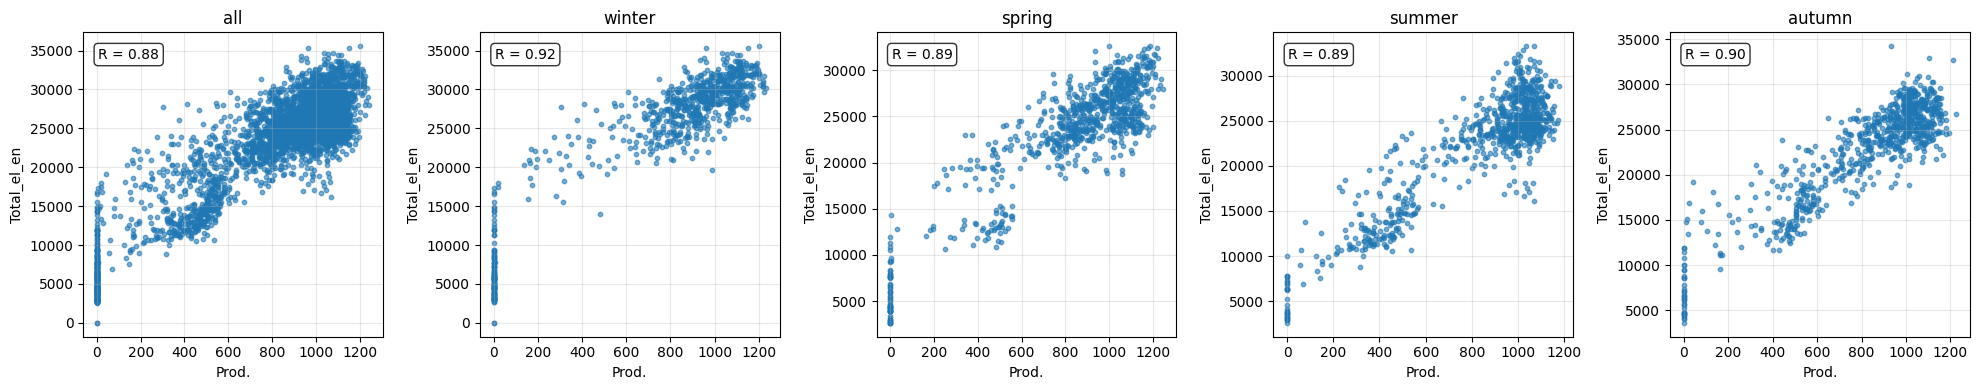

In [23]:
# выберем признаки для диаграммы рассеяния
x_feature = 'Prod.'        # Ось X
y_feature = 'Total_el_en'  # Ось Y

# формируем полный путь к файлу с графиками
file_path_3 = os.path.join(output_dir, "Prod_vs_energy_season.png")


# создадим полотно с 5 подграфиками
fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 4)) # figsize=(ширина, высота)

# цикл по каждому датасету
for idx, (dataset_name, df) in enumerate(dfs.items()):
    # проверка, что датасет не пустой
    if df.empty:
        print(f"Датасет '{dataset_name}' пустой, пропускаем график.")
        # добавим текст на график, что данных нет
        axes[idx].set_title(f'{dataset_name} (Нет данных)')
        axes[idx].text(0.5, 0.5, 'Нет данных', horizontalalignment='center', verticalalignment='center', transform=axes[idx].transAxes)
        continue

    # строим диаграмму рассеяния на текущей оси (axes[idx])
    axes[idx].scatter(df[x_feature], df[y_feature], alpha=0.6, label=dataset_name, s=10) # s - размер точек

    # добавляем заголовок к подграфику
    axes[idx].set_title(f'{dataset_name}')

    # подписываем оси
    axes[idx].set_xlabel(x_feature)
    axes[idx].set_ylabel(y_feature)

    # добавляем сетку
    axes[idx].grid(True, alpha=0.3)

    # вычисляем и отображаем коэффициент корреляции Пирсона
    if len(df) > 1: # нужно хотя бы 2 точки для корреляции
        correlation = df[x_feature].corr(df[y_feature])
        # отображаем R в углу подграфика
        axes[idx].text(0.05, 0.95, f'R = {correlation:.2f}', transform=axes[idx].transAxes,
                       verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# устраняем наложение графиков
plt.tight_layout()
# сохраним график в файл
plt.savefig(file_path_3, dpi=300) # dpi для высокого разрешения
plt.show()


## 5. Создание полносвязной нейронной сети (DL).

5.1. Создаем ф-цию для построения полносвязной нейронной сети. 

In [24]:
# функция создания полносвязной нейронной сети, с использованием tf.keras
# аргументы указаны в скобках: input_dim -кол-во нейронов во входном слое
# списком, например [64,32] - 2 скрытых слоя с 64 и 32 нейронами
# функция активации Relu
# dropout, при 0.0 - не используется в этой модели (используют для борьбы с переобучением (0.0 - 1.0))
def create_neural_network(input_dim, hidden_layers, activation='relu', dropout_rate=0.0):
    # создаем контейнер, в который будут добавляться слои
    model = tf.keras.Sequential()

    # добавляем Input слой в начало
    model.add(tf.keras.layers.Input(shape=(input_dim,))) 

    # добавляем первый Dense
    model.add(tf.keras.layers.Dense(hidden_layers[0], activation=activation))

    # добавляем Dropout если указан при объявлении функции
    if dropout_rate > 0:
        model.add(tf.keras.layers.Dropout(dropout_rate))

    # добавляем скрытые слои, их кол-во задано при объявл. функции (hidden_layers)
    for units in hidden_layers[1:]:
        model.add(tf.keras.layers.Dense(units, activation=activation))
        if dropout_rate > 0:
            model.add(tf.keras.layers.Dropout(dropout_rate))

    # добавляем выходной слой с одним нейроном, без активации
    model.add(tf.keras.layers.Dense(1))
# возвращаем созданную модель
    return model


5.2. Создаем ф-цию для обучения модели с заданными параметрами.

In [25]:
# создаем функцию обучения модели с жестко заданными параметрами
def train_model_with_hyperparameters(df, dataset_name, features, target,
                                   learning_rate=0.001, batch_size=32,
                                   hidden_layers=[64, 32], activation='relu',
                                   dropout_rate=0.0, epochs=100):
    # выводим информацию для идентификации процесса
    # print(f"Обучение модели для: {dataset_name}")
    # print(f"Параметры: LR={learning_rate}, BS={batch_size}, Layers={hidden_layers}, Activation={activation}, Dropout={dropout_rate}")
    # print(f"Размер данных: {len(df)}")
    

    # подготовка данных
    X = df[features]
    y = df[target]

    # разделение на обучающую (80%) и тестовую (20%) выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=False
    )

    if len(X_train) < 10:  # Проверка на минимальный размер
        print(f"Недостаточно данных для {dataset_name}, пропускаем...")
        return None, None, None, None, None, None, 0

    # стандартизация
    scaler_X = StandardScaler()
    scaler_y = StandardScaler()

    X_train_scaled = scaler_X.fit_transform(X_train) # обучаем на тренировочной выборке
    X_test_scaled = scaler_X.transform(X_test) # применяем к тестовой выборке
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

    # создание модели
    input_dim = X_train.shape[1] # данные для входного слоя
    # создаем модель через функцию, определенную в предыдущем блоке
    model = create_neural_network(input_dim, hidden_layers, activation, dropout_rate)

    # компиляция модели
    # для оптимизации используем метод Adam
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='mse', metrics=['mae'])

    # сallbacks для того, что бы избежать переобучения
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10, restore_best_weights=True
    )
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.5, patience=5, min_lr=1e-7
    )

    # обучение модели
    start_time = time.time() # отследим затраты времени на обучение
    # запускаем обучение модели
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_test_scaled, y_test_scaled),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stopping, reduce_lr],
        verbose=0
    )
    training_time = time.time() - start_time

    # оценка модели
    # получаем предсказанные данные (стандартизованные)
    y_pred_scaled = model.predict(X_test_scaled).flatten()
    # преобразуем предсказанные данные в исходный масштаб
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()
    # преобразуем тестовые данные в исходный масштаб
    y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten()
    # вычисляем метрики для оценки модели
    r2 = r2_score(y_test_original, y_pred)
    mse = mean_squared_error(y_test_original, y_pred)
    mae = np.mean(np.abs(y_test_original - y_pred))

    # print(f"Результаты для {dataset_name}:")
    # print(f"  R²: {r2:.4f}")
    # print(f"  MSE: {mse:.4f}")
    # print(f"  MAE: {mae:.4f}")
    # print(f"  Время обучения: {training_time:.2f} секунд")

    return model, scaler_X, scaler_y, history, r2, mse, training_time

5.3. Создаем ф-цию для подбора лучших параметров обучения модели.

In [26]:
# создаем функцию для подбороа лучших параметров обучения
def hyperparameter_tuning_for_dataset(df, dataset_name, features, target):
    # выводим информацию для идентификации процесса
    # print(f"ПОДБОР ГИПЕРПАРАМЕТРОВ ДЛЯ: {dataset_name}")
    
    # определяем сетку гиперпараметров
    # создаем словать, ключи - имена гиперпараметров, а значения - возможные значения для перебора
    param_grid = {
        'learning_rate': [0.001, 0.0001], # скорость обучения (шаг, с которым модель корректирует веса), влияет на точность и время обучения
        'batch_size': [16, 32], # кол-во примеров, которые сеть обрабатывает за одну итерацию,  влияет на точность и время обучения
        'hidden_layers': [[64, 32], [128, 64, 32]], # два варианта архитектуры скрытых слоев
        'activation': ['relu', 'tanh'], # функции активации (вставляется в каждый скрытый слой), определяет ф-цию зависимости выхода от входа
        'dropout_rate': [0.0, 0.2], # определяет вероятность обнуления части нейронов при обучении
        'epochs': [50]
    }
# переменная для хранения лучшего MSE
    best_score = float('inf')
    # переменная для хранения лучших параметров
    best_params = None
    # переменная для хранения лучшей модели
    best_model = None
    # переменная для хранения лучшего скалера лучшей модели
    best_scaler_X = None
    # переменная для хранения лучшего скалера таргета лучшей модели
    best_scaler_y = None
    # история обучения лучшей модели
    best_history = None
    # время обучения лучшей модели
    best_training_time = 0

    # генерация всех возможных комбинаций параметров
    param_combinations = list(product(
        param_grid['learning_rate'],
        param_grid['batch_size'],
        param_grid['hidden_layers'],
        param_grid['activation'],
        param_grid['dropout_rate'],
        param_grid['epochs']
    ))
    # подсчитываем кол-во всех возможных комбинаций параметров
    total_combinations = len(param_combinations)
    # print(f"Всего комбинаций параметров: {total_combinations}")

    # перебор всех комбинаций
    # запускаем цикл обучения с перебором всех возможных комбинаций параметров
    for i, params in enumerate(param_combinations):
        learning_rate, batch_size, hidden_layers, activation, dropout_rate, epochs = params
        # вызываем, ранее объявленную функцию, для обучения модели с перебором параметров
        try:
            model, scaler_X, scaler_y, history, r2, mse, training_time = train_model_with_hyperparameters(
                df, dataset_name, features, target,
                learning_rate=learning_rate,
                batch_size=batch_size,
                hidden_layers=hidden_layers,
                activation=activation,
                dropout_rate=dropout_rate,
                epochs=epochs
            )

            if model is not None: # проверяем обучилась ли модель
                # используем MSE как основную метрику для сравнения
                if mse < best_score: # сравниваем с лучшим результатом
                    best_score = mse # если лучше, то обновляем
                    # сохраняем лучшие параметры
                    best_params = {
                        'learning_rate': learning_rate,
                        'batch_size': batch_size,
                        'hidden_layers': hidden_layers,
                        'activation': activation,
                        'dropout_rate': dropout_rate,
                        'epochs': epochs
                    }
                    # сохраняем остальные компоненты лучшей модели
                    best_model = model
                    best_scaler_X = scaler_X
                    best_scaler_y = scaler_y
                    best_history = history
                    best_training_time = training_time

                    # print(f"  Найдена лучшая модель! MSE: {best_score:.4f}")
                    # print(f"  Параметры: {best_params}")

        except Exception as e: # перехватываем любые ошибки в try
            print(f"  Ошибка при обучении: {e}")
            continue # переходим к обучению со следующим набором параметров

        # print(f"  Прогресс: {i+1}/{total_combinations} ({((i+1)/total_combinations)*100:.1f}%)")
    # возврат лучшей модели
    if best_model is not None: # проверяем была ли найдена лучшая модель
        # print(f"\nЛУЧШИЕ ПАРАМЕТРЫ ДЛЯ {dataset_name}:")
        # print(f"  MSE: {best_score:.4f}")
        # print(f"  R²: {r2:.4f}")  # Исправлено: используем r2 из последней успешной модели
        # print(f"  Параметры: {best_params}")
        # print(f"  Время обучения: {best_training_time:.2f} секунд")

        return best_model, best_scaler_X, best_scaler_y, best_history, best_score, best_params
    # если лучшая модель не найдена - выводим сообщения об ошибках
    else:
        print(f"Не удалось найти подходящую модель для {dataset_name}")
        return None, None, None, None, None, None


5.4. Обучаем 5 моделей.

In [27]:
# целевой параметр
target = 'Total_el_en'

# создаем словари для хранения параметров
models_dict = {} # хранит обученные модели: {'dataset_name': model_object}
scalers_dict = {} # хранит скалеры: {'dataset_name': {'X': scaler_X, 'y': scaler_y}}
histories_dict = {} # хранит историю обучения: {'dataset_name': history_object}
results_dict = {} # хранит метрики: {'dataset_name': {'r2': value, 'mse': value, 'mae': value}}
best_params_dict = {} # хранит лучшие параметры: {'dataset_name': {'param': value, ...}}


# запускаем цикл обучения моделей с подбором параметров для каждого датасета
for dataset_name, df in dfs.items():
    if len(df) > 0:  # проверяем, что датасет не пустой
        #  print(f"\nОбработка датасета: {dataset_name}") # вывод имени обрабатываемого датасета

        # подбор гиперпараметров - запускаем ф-цию, которую определиле в блоке выше
        model, scaler_X, scaler_y, history, mse, best_params = hyperparameter_tuning_for_dataset(
            df, dataset_name, features, target
        )

        if model is not None: # проверка, успешно ли прошел подбор параметров
            models_dict[dataset_name] = model # сохраняем модель в словарь
            scalers_dict[dataset_name] = {'X': scaler_X, 'y': scaler_y} # сохраняем скаляры в словарь
            histories_dict[dataset_name] = history # сохраняем историю в словать
            # сохраняем начальные метрики в словарь (mse - из блока выше)
            results_dict[dataset_name] = {'r2': 0, 'mse': mse}  # R² будет вычислено ниже
            # сохраняем лучшие параметры в словарь
            best_params_dict[dataset_name] = best_params

              # повторная оценка на той же валидационной выборке
            # Используем те же скалеры, которые были обучены внутри hyperparameter_tuning_for_dataset
            # на (80% от) df[features] и df[target], и использовались для обучения best_model.
            # сначала нужно снова разделить df на train и test (с тем же random_state и shuffle).
            X = df[features]
            y = df[target]
            X_train, X_test, y_train, y_test = train_test_split(
                X, y, test_size=0.2, random_state=42, shuffle=False
            )

            # применяем сохраненные скалеры (best_scaler_X, best_scaler_y) к этим выборкам
            # !!! ВАЖНО: НЕ вызываем fit_transform или fit, только transform !!!
            X_train_scaled = scaler_X.transform(X_train) # применяем уже обученный scaler_X
            X_test_scaled = scaler_X.transform(X_test)   # применяем уже обученный scaler_X
            y_train_scaled = scaler_y.transform(y_train.values.reshape(-1, 1)).flatten() # применяем уже обученный scaler_y
            y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()   # применяем уже обученный scaler_y

            # получение предсказаний от лучшей модели
            y_pred_scaled = model.predict(X_test_scaled).flatten() # предсказание в масштабе скалера
            # преобразование предсказаний и тестовых значений обратно в исходный масштаб
            # используем тот же сохраненный scaler_y для обратного преобразования
            y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten() # обратное преобразование предсказаний
            y_test_original = scaler_y.inverse_transform(y_test_scaled.reshape(-1, 1)).flatten() # Обратное преобразование тестовой выборки

            # вычисление дополнительных метрик
            r2 = r2_score(y_test_original, y_pred) # вычисление R²
            # обновление словаря результатов
            results_dict[dataset_name]['r2'] = r2 # сохранение R²
            results_dict[dataset_name]['mae'] = np.mean(np.abs(y_test_original - y_pred)) # вычисление и сохранение MAE

            # print(f"  Окончательный R²: {r2:.4f}") # Вывод R² для текущего датасета

    else:
        print(f"Датасет {dataset_name} пустой, пропускаем...")

print(f"\nОбучено {len(models_dict)} моделей")

5/5 [==============================] - 0s 0s/step

Обучено 5 моделей


## 6. Оценка результатов.

6.1. Создаем ф-цию для подготовки сводной таблицы с результатами обучения

In [28]:
# сбор и отображение результатов обучения разных моделей с подбором параметров
# создаем ф-цию для сбора и обобщения
def create_summary_table_with_params(results_dict, best_params_dict):
    # создаем список для хранения строк таблицы
    summary_data = []
# запускаем цикл с перебором имен датасетов
    for dataset_name in results_dict.keys():
        metrics = results_dict[dataset_name] # получаем словарь с метриками
        params = best_params_dict.get(dataset_name, {}) # получаем словарь с параметрами
# добавляем новые строки с словать summary_data
        summary_data.append({
            'Dataset': dataset_name,
            'R²': metrics.get('r2', 0),
            'MSE': metrics.get('mse', 0),
            'RMSE': metrics.get('mse', 0) ** 0.5,
            'MAE': metrics.get('mae', 0),
            'Learning_Rate': params.get('learning_rate', 'N/A'),
            'Batch_Size': params.get('batch_size', 'N/A'),
            'Hidden_Layers': str(params.get('hidden_layers', 'N/A')),
            'Activation': params.get('activation', 'N/A'),
            'Dropout_Rate': params.get('dropout_rate', 'N/A'),
            'Epochs': params.get('epochs', 'N/A')
        })
# преобразуем созданный список в dataframe
    summary_df = pd.DataFrame(summary_data)

    # cортируем по R² (лучшие результаты сверху)
    summary_df = summary_df.sort_values('R²', ascending=False).reset_index(drop=True)

    # округление чисел
    summary_df['R²'] = summary_df['R²'].round(4)
    summary_df['MSE'] = summary_df['MSE'].round(4)
    summary_df['RMSE'] = summary_df['RMSE'].round(4)
    summary_df['MAE'] = summary_df['MAE'].round(4)

    return summary_df


6.2. Создаем сводную таблицу и сохраняем её в файл xlsx.

In [29]:
# создаем сводную таблицу
summary_table = create_summary_table_with_params(results_dict, best_params_dict)
print("Сводная таблица результатов обучения с лучшими параметрами:")
print(summary_table)

# Создаем папку для хранения результатов
results_folder = "Результаты_DL"
os.makedirs(results_folder, exist_ok=True)
# формируем путь к файлу внутри папки
file_path_4 = os.path.join(results_folder, "DL_summary_with_params.xlsx")

# сохраняем результаты
# summary_table.to_csv('neural_network_summary_with_params.csv', index=False)
summary_table.to_excel(file_path_4, index=False, sheet_name='Свод')
print(f"\nРезультаты сохранены в файл: Результаты_DL\DL_summary_with_params.csv")

Сводная таблица результатов обучения с лучшими параметрами:
  Dataset      R²           MSE       RMSE        MAE  Learning_Rate  \
0  winter  0.9753  1.649706e+06  1284.4088  1014.1161          0.001   
1     all  0.9677  1.898497e+06  1377.8595  1071.5113          0.001   
2  spring  0.9633  2.387370e+06  1545.1116  1187.7687          0.001   
3  summer  0.9584  2.173779e+06  1474.3742  1125.6599          0.001   
4  autumn  0.9529  1.166298e+06  1079.9526   834.4546          0.001   

   Batch_Size  Hidden_Layers Activation  Dropout_Rate  Epochs  
0          32  [128, 64, 32]       tanh           0.0      50  
1          16       [64, 32]       tanh           0.0      50  
2          32       [64, 32]       tanh           0.0      50  
3          16  [128, 64, 32]       relu           0.0      50  
4          32  [128, 64, 32]       relu           0.0      50  

Результаты сохранены в файл: Результаты_DL\DL_summary_with_params.csv


## 7. Сохранение обученных моделей, скалеров и лучших параметров для дальнейшего использования.

7.1. Создаем ф-цию для сохранения моделей, скалеров и лучших параметров.

In [30]:
# создаем ф-цию для сохранения моделей
def save_models_and_scalers_keras_format(models_dict, scalers_dict, best_params_dict, results_dict, summary_table_arg):
    # создаем директорию для сохранения
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    models_dir = f"DL_models_keras_{timestamp}"
    os.makedirs(models_dir, exist_ok=True)

    print(f"Создана директория для сохранения: {models_dir}")

    # запускаем цикл для сохранения каждой модели в своем файле *.keras
    for dataset_name in models_dict.keys():
        # формируем имя файла, сохраняем модель нейронной сети
        model_path = os.path.join(models_dir, f"model_{dataset_name}.keras")
        models_dict[dataset_name].save(model_path)
        print(f"Сохранена модель для {dataset_name}: {model_path}")

        # сохраняем скалеры
        # путь для сохранения скалеров
        scaler_X_path = os.path.join(models_dir, f"scaler_X_{dataset_name}.joblib")
        scaler_y_path = os.path.join(models_dir, f"scaler_y_{dataset_name}.joblib")
        # сохранение скалеров
        joblib.dump(scalers_dict[dataset_name]['X'], scaler_X_path)
        joblib.dump(scalers_dict[dataset_name]['y'], scaler_y_path)
        print(f"Сохранены скалеры для {dataset_name}: {scaler_X_path}, {scaler_y_path}")

    # сохраняем лучшие параметры
    # путь для файла с лучшими параметрами
    params_path = os.path.join(models_dir, "best_parameters.json")
    with open(params_path, 'w', encoding='utf-8') as f: # открываем файл на запись
        json.dump(best_params_dict, f, indent=2, ensure_ascii=False) # сохраняем файле
    print(f"Сохранены лучшие параметры: {params_path}")

    # сохраняем результаты
    # путь для файла с результатами
    results_path = os.path.join(models_dir, "results.json")
    with open(results_path, 'w', encoding='utf-8') as f: # открываем файл на запись
        json.dump(results_dict, f, indent=2, ensure_ascii=False) # сохраняем файл с результатами
    print(f"Сохранены результаты: {results_path}")

    # сохраняем сводную таблицу (используем аргумент функции)
    #  путь для файла с таблицей
    summary_path = os.path.join(models_dir, "summary_table.csv")
    summary_table_arg.to_csv(summary_path, index=False) # <-- Используем summary_table_arg
    print(f"Сохранена сводная таблица: {summary_path}")

    # создаем файл с информацией о сохранении
    info_path = os.path.join(models_dir, "save_info.txt")
    with open(info_path, 'w', encoding='utf-8') as f:
        f.write(f"Дата сохранения: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
        f.write(f"Количество моделей: {len(models_dict)}\n")
        f.write(f"Датасеты: {list(models_dict.keys())}\n")
        f.write(f"Параметры сохранены: {len(best_params_dict)}\n")
        f.write(f"Результаты сохранены: {len(results_dict)}\n")
        f.write(f"Использован формат: .keras (формат Keras)\n")
    print(f"Сохранена информация о сохранении: {info_path}")

    print(f"\nВсе модели успешно сохранены в директорию: {models_dir}")
    return models_dir



7.2. Сохранение моделей, скалеров и параметров.

In [31]:
# сохраняем все модели в формате *.keras
saved_dir_keras = save_models_and_scalers_keras_format(models_dict, scalers_dict, best_params_dict, results_dict, summary_table)

Создана директория для сохранения: DL_models_keras_20251125_132726
Сохранена модель для all: DL_models_keras_20251125_132726\model_all.keras
Сохранены скалеры для all: DL_models_keras_20251125_132726\scaler_X_all.joblib, DL_models_keras_20251125_132726\scaler_y_all.joblib
Сохранена модель для winter: DL_models_keras_20251125_132726\model_winter.keras
Сохранены скалеры для winter: DL_models_keras_20251125_132726\scaler_X_winter.joblib, DL_models_keras_20251125_132726\scaler_y_winter.joblib
Сохранена модель для spring: DL_models_keras_20251125_132726\model_spring.keras
Сохранены скалеры для spring: DL_models_keras_20251125_132726\scaler_X_spring.joblib, DL_models_keras_20251125_132726\scaler_y_spring.joblib
Сохранена модель для summer: DL_models_keras_20251125_132726\model_summer.keras
Сохранены скалеры для summer: DL_models_keras_20251125_132726\scaler_X_summer.joblib, DL_models_keras_20251125_132726\scaler_y_summer.joblib
Сохранена модель для autumn: DL_models_keras_20251125_132726\mod

## 8. Развертывание.

8.1. Создаем ф-цию для предсказаний расхода эл.энергии

In [32]:
# создаем ф-цию для предсказания потребл. эл.эн (с учетом временных лагов)
# loaded_models - словарь с обученными моделями
# loaded_scalers -  словарь со скалерамми
def predict_with_proper_lags(loaded_models, loaded_scalers, future_dates, future_production, df_train):
    # создаем пустой словарь для наполнения результатами
    results = []

    # извлекаем последние значения из обучающих данных для лагов
    last_el_value = df_train['Total_el_en'].iloc[-1] if len(df_train) > 0 else 500
    last_prod_value = df_train['Prod.'].iloc[-1] if len(df_train) > 0 else 500
    # запускаем цикл перебора по парам date и prod
    for i, (date, prod) in enumerate(zip(future_dates, future_production)):
        # определяем сезон прогнозирования по дате
        month = date.month
        if month in (12, 1, 2):
            season = 'winter'
        elif month in (3, 4, 5):
            season = 'spring'
        elif month in (6, 7, 8):
            season = 'summer'
        else:
            season = 'autumn'

        # используем модель и скалеры для соответствующего сезона
        # если найдена сезонная модель - используем её
        # иначе используем годовую (else - ниже)
        if season in loaded_models:
            model = loaded_models[season]
            scalers = loaded_scalers[season]

            # создаем массив с признаками
            X_single = np.array([[prod, month, last_el_value, last_prod_value,
                                last_el_value, last_prod_value,
                                np.sin(2 * np.pi * month / 12),
                                np.cos(2 * np.pi * month / 12)]])

            
            X_scaled = scalers['X'].transform(X_single)

            # предсказание
            y_pred_scaled = model.predict(X_scaled)[0][0] # предсказанные данные в масштабе скалера
            y_pred = scalers['y'].inverse_transform([[y_pred_scaled]])[0][0] # преобразование в исходный масштаб

            results.append({ # добавляем результаты в список
                'Date': date.strftime('%Y-%m-%d'),
                'Production': prod,
                'Season': season,
                'Predicted_Energy': round(y_pred, 2),
                'Energy_Per_Unit': round(y_pred/prod, 2) if prod > 0 else 0
            })
        else:
            # используем общую модель (при отсутствии сезонной)
            model = loaded_models['all'] # получаем общую модель
            scalers = loaded_scalers['all'] # получаем скалеры для общей модели
            # создаем массив с признаками
            X_single = np.array([[prod, month, last_el_value, last_prod_value,
                                last_el_value, last_prod_value,
                                np.sin(2 * np.pi * month / 12),
                                np.cos(2 * np.pi * month / 12)]])
            # стандартизация (используем те же параметры, что и при обучении)
            X_scaled = scalers['X'].transform(X_single)
            # предсказанные данные в масштабе скалера
            y_pred_scaled = model.predict(X_scaled)[0][0]
            # преобразование в исходный масштаб
            y_pred = scalers['y'].inverse_transform([[y_pred_scaled]])[0][0]
            # добавляем результаты в список
            results.append({
                'Date': date.strftime('%Y-%m-%d'),
                'Production': prod,
                'Season': 'all',
                'Predicted_Energy': round(y_pred, 2),
                'Energy_Per_Unit': round(y_pred/prod, 2) if prod > 0 else 0
            })
    # возврат результата в виде dataframe
    return pd.DataFrame(results)



8.2. Загрузка обученных моделей, скалеров и данных.

In [33]:
# создаем ф-цию для загрузки моделей (model_dir - откуда качаем)
def load_models_and_scalers_from_directory(models_dir):
    # создаем пустые словари для моделей и скалеров
    loaded_models = {}
    loaded_scalers = {}

    # найдем все файлы моделей .keras в директории
    model_files = glob.glob(os.path.join(models_dir, "model_*.keras"))
    # запускаем цикл загрузки
    for model_file in model_files:
        # извлекаем имя датасета из имени файла модели (например, из model_winter.keras -> winter)
        filename = os.path.basename(model_file)
        # оставляем только имя dataset, отсекаем лишнее
        dataset_name = filename.replace("model_", "").replace(".keras", "")

        # загружаем модель
        # добавляем загруженную модель в словарь loaded_models
        loaded_models[dataset_name] = tf.keras.models.load_model(model_file)
        print(f"Загружена модель для {dataset_name}: {model_file}")

        # загружаем соответствующие скалеры
        scaler_X_path = os.path.join(models_dir, f"scaler_X_{dataset_name}.joblib")
        scaler_y_path = os.path.join(models_dir, f"scaler_y_{dataset_name}.joblib")
        # проверяем наличие одновременно двух файлов скалеров
        if os.path.exists(scaler_X_path) and os.path.exists(scaler_y_path):
            loaded_scalers[dataset_name] = { # добавляем загруженные скалеры в словарь loaded_scalers
                'X': joblib.load(scaler_X_path),
                'y': joblib.load(scaler_y_path)
            }
            print(f"Загружены скалеры для {dataset_name}: {scaler_X_path}, {scaler_y_path}")
        else:
            print(f"Файлы скалеров для {dataset_name} не найдены! Путь: {scaler_X_path} или {scaler_y_path}")
            return None, None # Ошибка, если скалеры не найдены

    return loaded_models, loaded_scalers # возвращает оба созданных словаря

# вызываем ф-цию и загружаем модели и скадеоы
loaded_models, loaded_scalers = load_models_and_scalers_from_directory(saved_dir_keras)

# проверка, успешно ли загрузились модели и скалеры
if loaded_models is not None and loaded_scalers is not None:
    print("\n--- Загрузка завершена ---")
    print(f"Загружено моделей: {len(loaded_models)}")
    print(f"Загружено пар скалеров: {len(loaded_scalers)}")
    print(f"Доступные датасеты: {list(loaded_models.keys())}")
else:
    print("\n--- ОШИБКА ЗАГРУЗКИ ---")
    print("Не удалось загрузить модели или скалеры. Проверьте путь к директории и наличие файлов.")



Загружена модель для all: DL_models_keras_20251125_132726\model_all.keras
Загружены скалеры для all: DL_models_keras_20251125_132726\scaler_X_all.joblib, DL_models_keras_20251125_132726\scaler_y_all.joblib
Загружена модель для autumn: DL_models_keras_20251125_132726\model_autumn.keras
Загружены скалеры для autumn: DL_models_keras_20251125_132726\scaler_X_autumn.joblib, DL_models_keras_20251125_132726\scaler_y_autumn.joblib
Загружена модель для spring: DL_models_keras_20251125_132726\model_spring.keras
Загружены скалеры для spring: DL_models_keras_20251125_132726\scaler_X_spring.joblib, DL_models_keras_20251125_132726\scaler_y_spring.joblib
Загружена модель для summer: DL_models_keras_20251125_132726\model_summer.keras
Загружены скалеры для summer: DL_models_keras_20251125_132726\scaler_X_summer.joblib, DL_models_keras_20251125_132726\scaler_y_summer.joblib
Загружена модель для winter: DL_models_keras_20251125_132726\model_winter.keras
Загружены скалеры для winter: DL_models_keras_20251

8.3. Загружаем период предсказания и планируемые объемы пр-ва, запускаем ф-цию предсказания.

In [35]:
# Загружаем Excel-файл с планом производства на период
df = pd.read_excel("D:\ML_Energ\Prod_plan.xlsx", sheet_name="202511")

# Проверяем, что столбцы есть
print(df.head())


# преобразуем столбец "Дата" к datetime
future_dates = pd.to_datetime(df['Date'])  
# собираем план в список
future_production = df['Prod_plan'].tolist()  

# Проверяем
print(future_dates)
print(future_production)

        Date  Prod_plan
0 2025-11-01    2898.69
1 2025-11-02    2898.69
2 2025-11-03    3463.82
3 2025-11-04    3463.82
4 2025-11-05    3463.82
0    2025-11-01
1    2025-11-02
2    2025-11-03
3    2025-11-04
4    2025-11-05
5    2025-11-06
6    2025-11-07
7    2025-11-08
8    2025-11-09
9    2025-11-10
10   2025-11-11
11   2025-11-12
12   2025-11-13
13   2025-11-14
14   2025-11-15
15   2025-11-16
16   2025-11-17
17   2025-11-18
18   2025-11-19
19   2025-11-20
20   2025-11-21
21   2025-11-22
22   2025-11-23
Name: Date, dtype: datetime64[ns]
[2898.69, 2898.69, 3463.82, 3463.82, 3463.82, 3463.82, 3463.82, 3463.82, 3463.82, 2540.96, 2540.96, 2540.96, 2540.96, 2540.96, 2540.96, 2540.96, 3548.32, 3548.32, 3548.32, 3548.32, 3548.32, 3548.32, 3548.32]


In [36]:
# укажем начало и конец прогнозируемого периода
# future_dates = pd.date_range('2025-10-01', '2025-10-10') # Пример: 10 дней в октябре 2025
# план производства на прогнозируемый период
# future_production = [568, 685, 986, 564, 587, 987, 889, 945, 1058, 1198]

# проверим наличие всех необходимых переменных
# словарь для отслеживания состояния переменных
required_vars = {
    'loaded_models': loaded_models,
    'loaded_scalers': loaded_scalers,
    # 'df_prod_el': df_prod_el, # Закомментировано, так как df_prod_el не определен в этом фрагменте
    'future_dates': future_dates,
    'future_production': future_production
}

# Проверка на None
missing_or_none = [name for name, obj in required_vars.items() if obj is None]

# Проверка существования в globals() (опционально, но показывает намерение)
# missing_from_globals = [name for name in required_vars.keys() if name not in globals()]

# объединяем проверки: переменная отсутствует или равна None
all_issues = []
if missing_or_none:
    all_issues.append(f"Следующие переменные равны None: {missing_or_none}")

# проверяем df_prod_el отдельно, так как она не была загружена в этом фрагменте
if 'df_prod_el' not in globals() or df_prod_el is None:
    all_issues.append("Переменная 'df_prod_el' не определена или равна None.")

if all_issues:
    print("\n--- ОШИБКИ / ПРЕДУПРЕЖДЕНИЯ ---")
    for issue in all_issues:
        print(f"  - {issue}")
    print("---")
    print("Прогноз не выполнен из-за отсутствия необходимых переменных.")
else:
    # Все переменные определены и не равны None
    print("\n Все необходимые переменные определены")
    print(f"  - Загружено моделей: {len(loaded_models)}")
    print(f"  - Загружено пар скалеров: {len(loaded_scalers)}")
    print(f"  - Доступные датасеты: {list(loaded_models.keys())}")
    print(f"  - future_dates: {future_dates}")
    print(f"  - future_production: {future_production}")
    print(f"  - df_prod_el: определена и не равна None")

    # запускаем ф-цию прогнозирования с учетом временных лагов
    seasonal_predictions = predict_with_proper_lags(
        loaded_models, loaded_scalers, future_dates, future_production, df_prod_el
    )

    
    print("ПРОГНОЗ С УЧЕТОМ СЕЗОННОСТИ И ИСТОРИЧЕСКИХ ДАННЫХ")
    print(seasonal_predictions)
    print(f"\nОбщее прогнозное потребление: {seasonal_predictions['Predicted_Energy'].sum():.2f} кВт·ч")
    print(f"Среднее потребление в день: {seasonal_predictions['Predicted_Energy'].mean():.2f} кВт·ч")
    print(f"Средняя эффективность: {seasonal_predictions['Energy_Per_Unit'].mean():.2f} кВт·ч/ед. продукции")


 Все необходимые переменные определены
  - Загружено моделей: 5
  - Загружено пар скалеров: 5
  - Доступные датасеты: ['all', 'autumn', 'spring', 'summer', 'winter']
  - future_dates: 0    2025-11-01
1    2025-11-02
2    2025-11-03
3    2025-11-04
4    2025-11-05
5    2025-11-06
6    2025-11-07
7    2025-11-08
8    2025-11-09
9    2025-11-10
10   2025-11-11
11   2025-11-12
12   2025-11-13
13   2025-11-14
14   2025-11-15
15   2025-11-16
16   2025-11-17
17   2025-11-18
18   2025-11-19
19   2025-11-20
20   2025-11-21
21   2025-11-22
22   2025-11-23
Name: Date, dtype: datetime64[ns]
  - future_production: [2898.69, 2898.69, 3463.82, 3463.82, 3463.82, 3463.82, 3463.82, 3463.82, 3463.82, 2540.96, 2540.96, 2540.96, 2540.96, 2540.96, 2540.96, 2540.96, 3548.32, 3548.32, 3548.32, 3548.32, 3548.32, 3548.32, 3548.32]
  - df_prod_el: определена и не равна None
1/1 [==============================] - 0s 18ms/step
ПРОГНОЗ С УЧЕТОМ СЕЗОННОСТИ И ИСТОРИЧЕСКИХ ДАННЫХ
          Date  Production  Season  P

8.4. Сохраняем результаты предсказания DL модели в *.xlsx

In [42]:
# создаем функцию для сохранения результатов в файл *.xls
# predictions_df - dataframe с результатми, filename -укажем имя файла для сохранения результатов
def save_predictions_to_excel(predictions_df, filename_template="Прогнозы/energy_predictions_{timestamp}.xlsx"):
    # формируем строку с текущей датой
    current_date_str = datetime.now().strftime("%Y%m%d")
    # подставляем дату в шаблон имени файла
    filename = filename_template.format(timestamp=current_date_str)
    # создаем папку для хранения прогнозов
    folder = os.path.dirname(filename)
    if folder and not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
    # создаем объект для для записи в *.xls (с помощью биб-ки openpyx)
    with pd.ExcelWriter(filename, engine='openpyxl') as writer:
        # выполняем запись предсказанных данных в xls
        predictions_df.to_excel(writer, sheet_name='Predictions', index=False)

        # дополнительный лист с общей статистикой
        stats_data = {
            'Metric': [
                'Всего эл.эн. за период (кВт*ч)',
                'Среднее потребление эл.эн. в сутки (кВт*ч)',
                'Всего продукции за период (куб.м.)',
                'Средний выпуск продукции в сутки (куб.м)',
                'Удельный расход эл.эн/куб.м (кВт*ч/куб.м)',
                'Период планирования'
            ],
            'Value': [
                predictions_df['Predicted_Energy'].sum(),
                predictions_df['Predicted_Energy'].mean(),
                predictions_df['Production'].sum(),
                predictions_df['Production'].mean(),
                predictions_df['Energy_Per_Unit'].mean(),
                '2025-10-01 to 2025-10-10'
            ]
        }
        stats_df = pd.DataFrame(stats_data)
        stats_df.to_excel(writer, sheet_name='Summary', index=False)

    print(f"Результаты прогноза сохранены в файл: {filename}")

# сохранение прогноза
save_predictions_to_excel(seasonal_predictions)

Результаты прогноза сохранены в файл: Прогнозы/energy_predictions_20251125.xlsx


## 9. Подготовка данных и функций для моделей ML (Random Forest и Linear Regression)

9.1. Подготовка данных.

In [43]:
# разделение dataframe на тренировочную и тестовые выборки
# аргументы: df (pd.DataFrame): входной DataFrame.
           # features (list): cписок названий столбцов-признаков.
           # target (str): название столбца-цели.
           # test_size (float): доля данных для тестовой выборки.
           # random_state (int): для воспроизводимости разделения.

def prepare_data(df, features, target, test_size=0.2, random_state=42):
    X = df[features]
    y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, shuffle=False
    )
    return X_train, X_test, y_train, y_test

9.2. Определение моделей и гиперпараметров в созданной функции .

In [44]:
# создаем ф-цию для определения моделей и их гиперпараметров для подбора
def define_models():
    # Модель 1: Random Forest
    rf_model = RandomForestRegressor(random_state=42)
    rf_param_grid = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Модель 2: Linear Regression (в пайплайне со скалером)
    lr_model = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LinearRegression())
    ])
    return rf_model, rf_param_grid, lr_model

9.3. Создаем ф-цию для обучение моделей.

In [45]:
# обучение Модели 1
def train_and_tune_rf(rf_model, rf_param_grid, X_train, y_train):
    print("  Подбор параметров для Random Forest...")
    rf_search = GridSearchCV(
        rf_model,
        rf_param_grid,
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1,
        verbose=0
    )
    rf_search.fit(X_train, y_train)
    return rf_search.best_estimator_, rf_search.best_params_, rf_search.refit_time_
    # обучение Модели 2
def train_lr(lr_model, X_train, y_train):
    print("  Обучение Linear Regression...")
    lr_model.fit(X_train, y_train)
    return lr_model


## 10. Создание функций для оценки моделей.

10.1. Создаем ф-цию для оценки моделей на тестовой выборке.

In [46]:
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    return r2, rmse, mae

10.2. Создаем ф-цию для добавления результатов обучения в отчет.

In [47]:
# аргументы: results_list (list): список для хранения результатов.
        # dataset_name (str): имя датасета.
        # model_name (str): имя модели.
        # r2 (float): R².
        # rmse (float): RMSE.
        # mae (float): MAE.
        # params (dict or str): параметры модели или 'N/A'.
        # training_time (float): время обучения.
    
def append_results(results_list, dataset_name, model_name, r2, rmse, mae, params, training_time):
            
    results_list.append({
        'dataset': dataset_name,
        'model': model_name,
        'R²': r2,
        'RMSE': rmse,
        'MAE': mae,
        'Best_Params': params,
        'Training_Time': training_time
    })


10.3. Создаем ф-цию для обновления словаря моделей.

In [48]:
# аргументы: models_dict (dict): словарь для хранения моделей.
        # dataset_name (str): имя датасета.
        # rf_model: обученная модель Random Forest.
        # lr_model: обученная модель Linear Regression. 
def update_models_dict(models_dict, dataset_name, rf_model, lr_model):
    
    models_dict[dataset_name] = {
        'RandomForest': rf_model,
        'LinearRegression': lr_model
    }

10.4. Создаем ф-цию для обновления словаря лучших моделях.

In [49]:
# аргументы: best_models_info (dict): словарь для хранения информации о моделях.
        # dataset_name (str): имя датасета.
        # rf_results (dict): {'model': ..., 'r2': ..., 'rmse': ..., 'mae': ..., 'params': ...}
        # lr_results (dict): {'model': ..., 'r2': ..., 'rmse': ..., 'mae': ..., 'params': ...} 
def update_best_models_info(best_models_info, dataset_name, rf_results, lr_results):
    
    best_models_info[dataset_name] = {
        'RandomForest': rf_results,
        'LinearRegression': lr_results
    }

## 11. Обучение моделей.

11.1. Обучим модели и выведем результаты обучения.

In [50]:
# создаем пустые словари и список для хранения результатов
models_dict = {}
results_list = []
best_models_info = {}

for dataset_name, df in dfs.items():
    print(f"\nОбработка датасета: {dataset_name}")
    print(f"Размер данных: {len(df)}")

    # применяем инжиниринг признаков
    df_feat = engineer_features(df)

    # подготовка данных
    X_train, X_test, y_train, y_test = prepare_data(df_feat, features, target)

    # определение моделей
    rf_model, rf_param_grid, lr_model = define_models()

    # обучение и подбор гиперпараметров
    best_rf_model, best_rf_params, rf_training_time = train_and_tune_rf(rf_model, rf_param_grid, X_train, y_train)
    trained_lr_model = train_lr(lr_model, X_train, y_train)

    # оценка моделей
    rf_r2, rf_rmse, rf_mae = evaluate_model(best_rf_model, X_test, y_test)
    lr_r2, lr_rmse, lr_mae = evaluate_model(trained_lr_model, X_test, y_test)

    # сохранение результатов и моделей
    append_results(results_list, dataset_name, 'RandomForest', rf_r2, rf_rmse, rf_mae, best_rf_params, rf_training_time)
    append_results(results_list, dataset_name, 'LinearRegression', lr_r2, lr_rmse, lr_mae, 'N/A', 0)

    update_models_dict(models_dict, dataset_name, best_rf_model, trained_lr_model)

    rf_info = {'model': best_rf_model, 'r2': rf_r2, 'rmse': rf_rmse, 'mae': rf_mae, 'params': best_rf_params}
    lr_info = {'model': trained_lr_model, 'r2': lr_r2, 'rmse': lr_rmse, 'mae': lr_mae, 'params': 'N/A'}
    update_best_models_info(best_models_info, dataset_name, rf_info, lr_info)

    # вывод результатов
    print(f"  Результаты для {dataset_name}:")
    print(f"    Random Forest - R²: {rf_r2:.4f}, RMSE: {rf_rmse:.4f}, MAE: {rf_mae:.4f}")
    print(f"    Linear Regression - R²: {lr_r2:.4f}, RMSE: {lr_rmse:.4f}, MAE: {lr_mae:.4f}")

print("\nЦикл обучения завершен.")



Обработка датасета: all
Размер данных: 3195
  Подбор параметров для Random Forest...
  Обучение Linear Regression...
  Результаты для all:
    Random Forest - R²: 0.9529, RMSE: 1664.9855, MAE: 1243.2957
    Linear Regression - R²: 0.9627, RMSE: 1481.5143, MAE: 1138.3191

Обработка датасета: winter
Размер данных: 782
  Подбор параметров для Random Forest...
  Обучение Linear Regression...
  Результаты для winter:
    Random Forest - R²: 0.9302, RMSE: 2159.1017, MAE: 1756.1956
    Linear Regression - R²: 0.9593, RMSE: 1647.5557, MAE: 1277.4491

Обработка датасета: spring
Размер данных: 828
  Подбор параметров для Random Forest...
  Обучение Linear Regression...
  Результаты для spring:
    Random Forest - R²: 0.8399, RMSE: 3226.6849, MAE: 2371.6606
    Linear Regression - R²: 0.9531, RMSE: 1745.7449, MAE: 1299.4724

Обработка датасета: summer
Размер данных: 827
  Подбор параметров для Random Forest...
  Обучение Linear Regression...
  Результаты для summer:
    Random Forest - R²: 0.924

11.2. Сохраним результаты обучения в файл *.xlsx

In [51]:
# 1. Создаем DataFrame из списка результатов
# results_list должен быть заполнен после цикла
summary_df = pd.DataFrame(results_list)

# 2. (Опционально) Проверяем структуру DataFrame
print("\nСводная таблица результатов:")
print(summary_df)

# 3. Сохраняем DataFrame в файл .xlsx
# Укажите имя файла
output_filename = 'ml_comparison_summary.xlsx'

# Сохраняем в Excel
summary_df.to_excel(output_filename, index=False, sheet_name='Model_Comparison')

print(f"\nСводная таблица результатов сохранена в файл: {output_filename}")



Сводная таблица результатов:
  dataset             model        R²         RMSE          MAE  \
0     all      RandomForest  0.952855  1664.985508  1243.295721   
1     all  LinearRegression  0.962673  1481.514258  1138.319143   
2  winter      RandomForest  0.930168  2159.101707  1756.195564   
3  winter  LinearRegression  0.959338  1647.555704  1277.449108   
4  spring      RandomForest  0.839887  3226.684892  2371.660596   
5  spring  LinearRegression  0.953132  1745.744917  1299.472363   
6  summer      RandomForest  0.924287  1988.510592  1383.878097   
7  summer  LinearRegression  0.948669  1637.309217  1168.016081   
8  autumn      RandomForest  0.895101  1612.471045  1218.918588   
9  autumn  LinearRegression  0.927575  1339.835637   989.378510   

                                         Best_Params  Training_Time  
0  {'max_depth': None, 'min_samples_leaf': 2, 'mi...       1.839171  
1                                                N/A       0.000000  
2  {'max_depth': None,

## 12. Развертывание.

12.1. Определяем директорию с сохраненными моделями.

In [52]:
# корневая папка, где хранятся ваши папки моделей
models_base_dir = '.' 

# находим все папки, начинающиеся с 'saved_models_keras_'
model_dirs = [d for d in os.listdir(models_base_dir) if os.path.isdir(d) and d.startswith('saved_models_keras_')]

# проверяем, что найдены папки и берем последнюю по дате в имени
if not model_dirs:
    raise FileNotFoundError("Папки с сохраненными моделями не найдены")

# сортируем по дате (январь — это впереди в строке, так как формат %Y%m%d_%H%M%S)
model_dirs_sorted = sorted(model_dirs, reverse=True)
latest_model_dir = model_dirs_sorted[0]

print(f"Используем последнюю папку с моделями: {latest_model_dir}")

FileNotFoundError: Папки с сохраненными моделями не найдены

12.2. Загрузка моделей и скалеров.

In [90]:
# загрузка моделей и скейлеров ---
datasets = ['all', 'winter', 'spring', 'summer', 'autumn']
loaded_models = {}
loaded_scalers = {}

for season in datasets:
    model_path = os.path.join(latest_model_dir, f"model_{season}.keras")
    scaler_X_path = os.path.join(latest_model_dir, f"scaler_X_{season}.joblib")
    scaler_y_path = os.path.join(latest_model_dir, f"scaler_y_{season}.joblib")

    if os.path.exists(model_path) and os.path.exists(scaler_X_path) and os.path.exists(scaler_y_path):
        loaded_models[season] = load_model(model_path, compile=False)
        loaded_scalers[season] = {
            "X": joblib.load(scaler_X_path),
            "y": joblib.load(scaler_y_path)
        }

print(f"Загружено моделей: {len(loaded_models)}")
print(f"Загружено скейлеров: {len(loaded_scalers)}")


Загружено моделей: 5
Загружено скейлеров: 5


12.3. Создаем ф-цию для предсказания объемов потр. эл.энергии.

In [91]:
# ф-ция предсказания
def predict_with_season_models(loaded_models, loaded_scalers, future_dates, future_production, df_history):
    results = []
    last_el = df_history['Total_el_en'].iloc[-1] if not df_history.empty else 500
    last_prod = df_history['Prod.'].iloc[-1] if not df_history.empty else 500

    for date, prod in zip(future_dates, future_production):
        month = date.month
        if month in (12,1,2):
            season = 'winter'
        elif month in (3,4,5):
            season = 'spring'
        elif month in (6,7,8):
            season = 'summer'
        else:
            season = 'autumn'

        if season not in loaded_models:
            season = 'all'

        model = loaded_models[season]
        scalers = loaded_scalers[season]

        X_single = pd.DataFrame(
            [[prod, month, last_el, last_prod, last_el, last_prod,
              np.sin(2*np.pi*month/12), np.cos(2*np.pi*month/12)]],
            columns=['Prod.', 'month', 'el_lag_1', 'prod_lag_1', 'el_ma_7', 'prod_ma_7', 'month_sin', 'month_cos']
        )
        X_scaled = scalers['X'].transform(X_single)
        y_scaled = model.predict(X_scaled)
        y_pred = scalers['y'].inverse_transform(y_scaled.reshape(-1, 1)).flatten()[0]

        results.append({
            'Date': date.strftime('%Y-%m-%d'),
            'Production': prod,
            'Season': season,
            'Predicted_Energy': round(y_pred, 2),
            'Energy_Per_Unit': round(y_pred / prod, 2)
        })

        last_el = y_pred
        last_prod = prod

    return pd.DataFrame(results)

12.4. Предсказание потребления эл.энергии.

In [92]:
predictions = predict_with_season_models(
    loaded_models,
    loaded_scalers,
    future_dates,
    future_production,
    df_history=df_prod_el
)

print("\nПРОГНОЗ НА ПЕРИОД:")
print(predictions)
print(f"\nСуммарное прогнозное потребление: {predictions['Predicted_Energy'].sum():,.2f} кВт·ч")
print(f"Средняя эффективность: {predictions['Energy_Per_Unit'].mean():.2f} кВт·ч/ед. продукции")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step

ПРОГНОЗ НА ПЕРИОД:
         Date  Production  Season  Predicted_Energy  Energy_Per_Unit
0  2025-10-01         568  autumn      18099.939453        31.870001
1  2025-10-02         685  autumn      19480.730469        28.440001
2  2025-10-03         986  autumn      23000.869141        23.330000
3  2025-10-04         564  autumn      18314.269531        32.470001
4  2025-10-05         587  autumn      18171.470703        30.959999
5  2025-10-06         987  autumn      22672.640625        22.969999
6  2025-10-07         889  autumn      21658.650391        24.360001
7  2025-10-08         945  autumn      22748.500

12.5. Сохраняем результаты предсказаний в файл *.xlsx.

In [93]:
# cохраняем в Excel
predictions.to_excel("energy_forecast_auto_path.xlsx", index=False)
print("\nПрогноз сохранён в файл: energy_forecast_auto_path.xlsx")



Прогноз сохранён в файл: energy_forecast_auto_path.xlsx


## 13. Сравнение разультатов предсказаний DL и ML моделей.

13.1. Построим графики для сравнения предсказаний моделей.

In [ ]:
# соберем результаты предсказаний
merged_results = pd.merge(
    predictions, # Результаты первой модели
    seasonal_predictions, # Результаты второй модели
    on='Date', # Объединяем по столбцу 'Date'
    suffixes=('_model1', '_model2') # Суффиксы для столбцов с одинаковыми именами
)


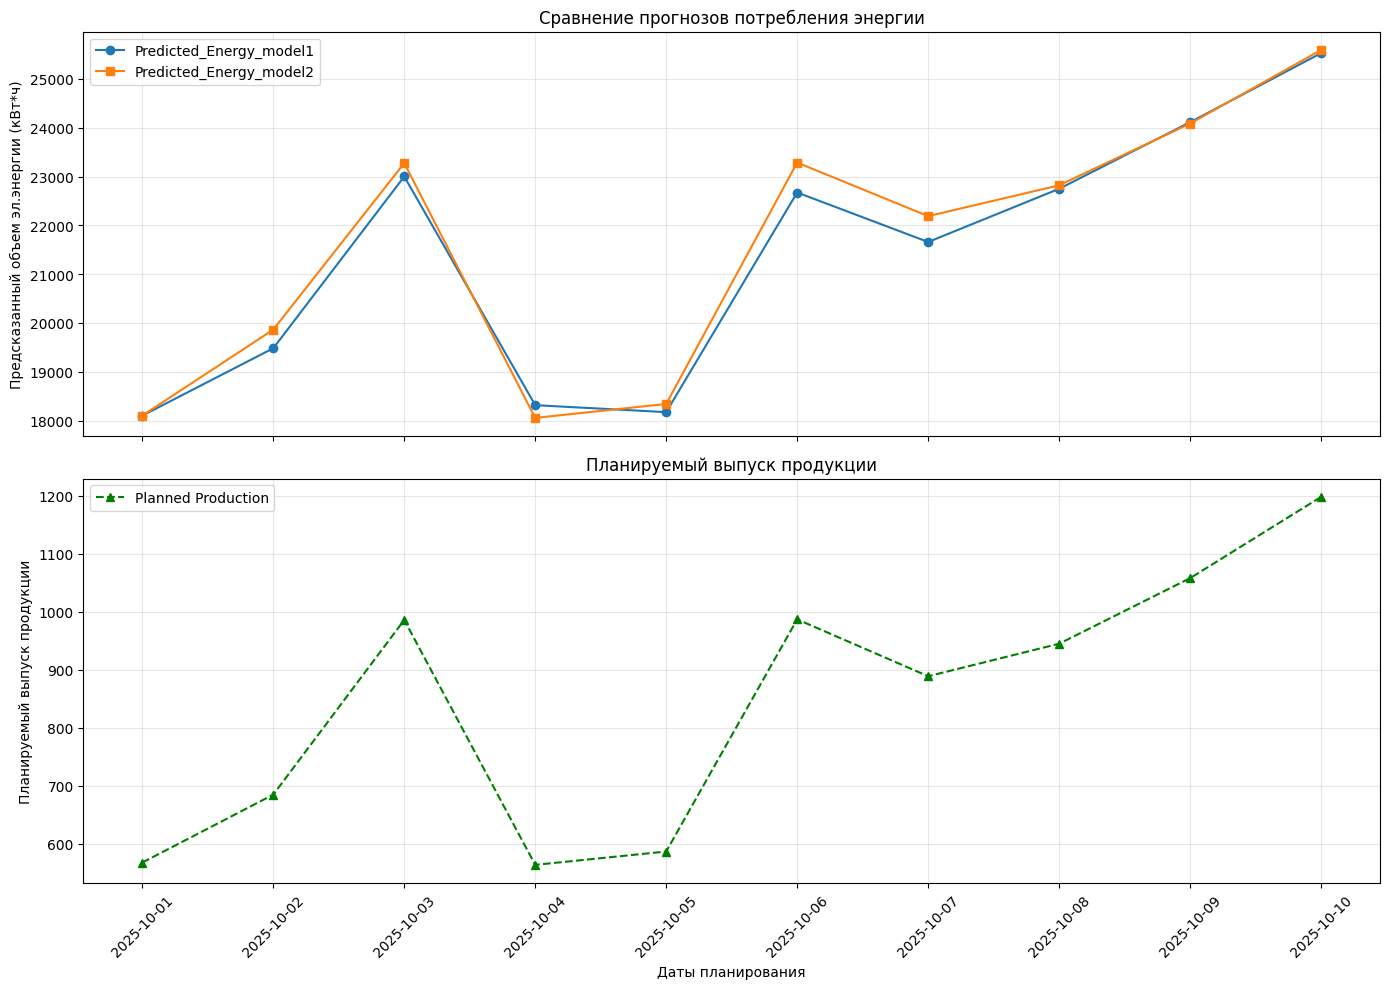

In [96]:
dates_for_plot = merged_results['Date'] 
production_for_plot = future_production 

# создаем полотно с двумя подграфиками
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10), sharex=True) # sharex=True обеспечивает общую ось X

# верхний график: Сравнение прогнозов DL и ML моделей
# Проверяем, есть ли столбцы с прогнозами
energy_cols = [col for col in merged_results.columns if 'Predicted_Energy' in col]
if len(energy_cols) >= 2:
    ax1.plot(dates_for_plot, merged_results[energy_cols[0]], label=energy_cols[0], marker='o', linestyle='-', linewidth=1.5)
    ax1.plot(dates_for_plot, merged_results[energy_cols[1]], label=energy_cols[1], marker='s', linestyle='-', linewidth=1.5)
    ax1.set_title('Сравнение прогнозов потребления энергии')
    ax1.set_ylabel('Предсказанный объем эл.энергии (кВт*ч)')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
else:
    ax1.text(0.5, 0.5, 'Недостаточно данных для графика энергии', horizontalalignment='center', verticalalignment='center', transform=ax1.transAxes)
    ax1.set_title('Сравнение прогнозов потребления энергии (ДАННЫЕ ОТСУТСТВУЮТ)')

# нижний график: Планируемый выпуск продукции
ax2.plot(dates_for_plot, production_for_plot, label='Planned Production', color='green', marker='^', linestyle='--', linewidth=1.5)
ax2.set_title('Планируемый выпуск продукции')
ax2.set_xlabel('Даты планирования') # Ось X только для нижнего графика, так как sharex=True
ax2.set_ylabel('Планируемый выпуск продукции')
ax2.grid(True, alpha=0.3)
ax2.legend()

# поворот подписей на оси X
plt.xticks(rotation=45)

# для устранения перекрытий
plt.tight_layout()
plt.savefig('DL_ML_1.png', dpi=300) # dpi для высокого разрешения
plt.show()


13.2. Сохраняем в xlsx предсказания двух моделей (DL и ML)

In [97]:
# оба DataFrame имеют столбец 'Date'
# bспользуем 'Date' как ключ для объединения
# suffixes - для объединения двух DataFrame, имеющих столбцы с одинаковыми именами
merged_results = pd.merge(
    predictions, # результаты DL модели
    seasonal_predictions, # результаты ML модели
    on='Date', # объединяем по столбцу 'Date'
    suffixes=('_model1', '_model2') # суффиксы для столбцов с одинаковыми именами
)


print("Объединённая таблица результатов:")
print(merged_results)

# cохранztv в файл Excel (.xlsx)
# укажем имя файла
output_filename = 'comparison_of_predictions.xlsx'

# сохраним DataFrame в Excel файл
merged_results.to_excel(output_filename, index=False, sheet_name='Predictions_Comparison')

print(f"\nОбъединённые результаты сохранены в файл: {output_filename}")

Объединённая таблица результатов:
         Date  Production_model1 Season_model1  Predicted_Energy_model1  \
0  2025-10-01                568        autumn             18099.939453   
1  2025-10-02                685        autumn             19480.730469   
2  2025-10-03                986        autumn             23000.869141   
3  2025-10-04                564        autumn             18314.269531   
4  2025-10-05                587        autumn             18171.470703   
5  2025-10-06                987        autumn             22672.640625   
6  2025-10-07                889        autumn             21658.650391   
7  2025-10-08                945        autumn             22748.500000   
8  2025-10-09               1058        autumn             24113.119141   
9  2025-10-10               1198        autumn             25528.699219   

   Energy_Per_Unit_model1  Production_model2 Season_model2  \
0               31.870001                568        autumn   
1               